Импортируем библиотеки

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Классы:

In [2]:
class my_PCA(): 
    def __init__(self, n_components=None): 
        self.components = n_components 
    
    def fit(self, X):
        '''
        Computes mean and std of dataset
        
        ----------
        Parameters:
        X: ndarray
        '''

        self.mean = X.mean(axis=0)
        X = X - self.mean
        self.std = X.std(axis=0) + 10 ** -9

        
    def transform(self, X):
        '''
        Transforms values into new basis coordinates
        
        ----------
        Parameters:
        X: ndarray
        '''
        Xc = X - self.mean
        Xm = Xc / self.std
        #_, S, V = np.linalg.svd(Xm, full_matrices=False)
        #L = np.power(S, 2)
        #F = V.T
        C = np.dot(Xm.T, Xm)
        L, F = np.linalg.eig(C)
        #L, F = L[::-1], F[::-1]
        Y = np.dot(Xm, F)
        return L, Y[:, :self.components]
     
    def fit_transform(self, X): 
        '''
        Fits and transforms values. Wow!
        (haven't used that anywhere)
        ----------
        Parameters:
        X: ndarray
        '''
        self.fit(X)
        L, Y = self.transform(X)
        return L, Y[:, :self.components]
    


class my_kNN(): 
    def __init__(self, n_neighbors=5): 
        self.n_neighbors = n_neighbors 
 
    def fit(self, X, y):
        '''
        Memorizes training coordinates
        
        ----------
        Parameters:
        X: ndarray
            values
        y: ndarray
            labels
        '''
        self.train_cords = X  #trainingX.fit_transform(X)
        self.ytrain = y
 
    def predict(self, X):
        '''
        Predicts labels of data. Predictions based on training data from my_kNN.fit()
        
        ----------
        Parameters:
        X: ndarray
        '''
        decisions = []
        counter = 0
        for x_cords in X:

            distances = np.linalg.norm(self.train_cords - x_cords, axis=1)
            neighbours = []
            indexes = []
            possible_names = self.ytrain.copy()
            names = []
            while len(names) < self.n_neighbors:
                i = np.argmin(distances)
                names.append(possible_names[i])
                indexes.append(i)
                
                distances = np.delete(distances, i)
                possible_names = np.delete(possible_names, i)
                decision = stats.mode(names)[0][0]    
                
            decisions.append(decision)


        return decisions

Датасет:

In [3]:
from mnist import load_mnist 
train, validation, test = load_mnist()

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [4]:
X = (train[0]).reshape(55000, 784)
labels = train[1]
X.shape

(55000, 784)

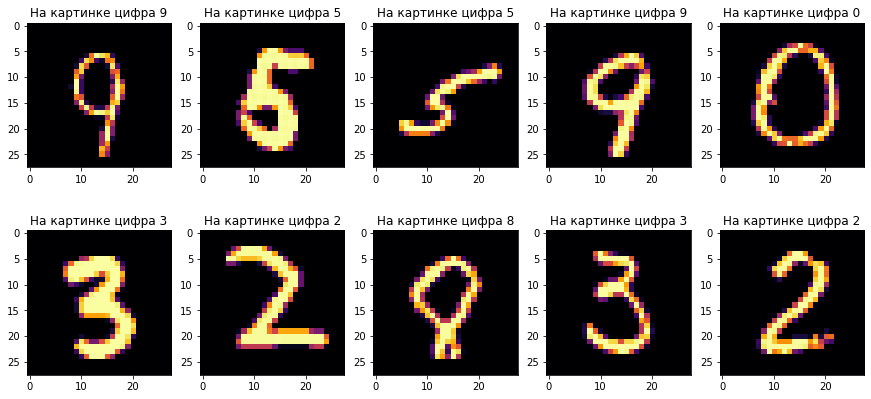

In [5]:
fig, ax = plt.subplots(2, 5, figsize = (15, 7))
for i in range(2):
    for j in range(5):
        a = np.random.randint(0, 55000)
        ax[i, j].imshow(X.reshape(55000, 28, 28)[a], cmap='inferno')
        ax[i, j].set_title(f'На картинке цифра {labels[a]}')

In [6]:
data = my_PCA(2)
X_eig, Y = data.fit_transform(X)

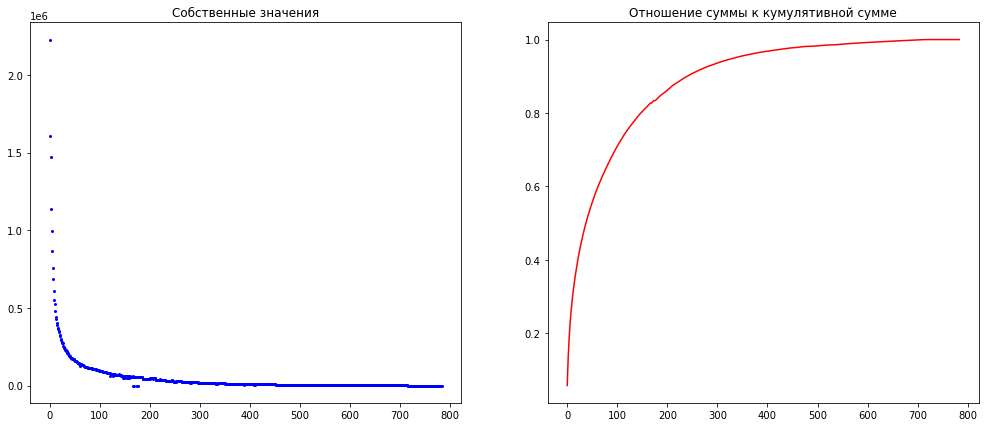

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
ax[0].set_title('Собственные значения')
ax[0].plot(X_eig, linestyle='', marker='o', color='b', ms=2)

S = np.cumsum(X_eig) / np.sum(X_eig)

ax[1].set_title('Отношение суммы к кумулятивной сумме')
ax[1].plot(S, color='red')

Чем больше собственное значение матрицы, тем больше дисперсии покрывает соответствующая главная компонента

In [8]:
S_all = np.sum(X_eig)
S_15 = np.sum(X_eig[:15])
print(f'Первые 15 главных компонент покрывают {int((S_15 / S_all) * 100)}% дисперсии')

Первые 15 главных компонент покрывают 33% дисперсии


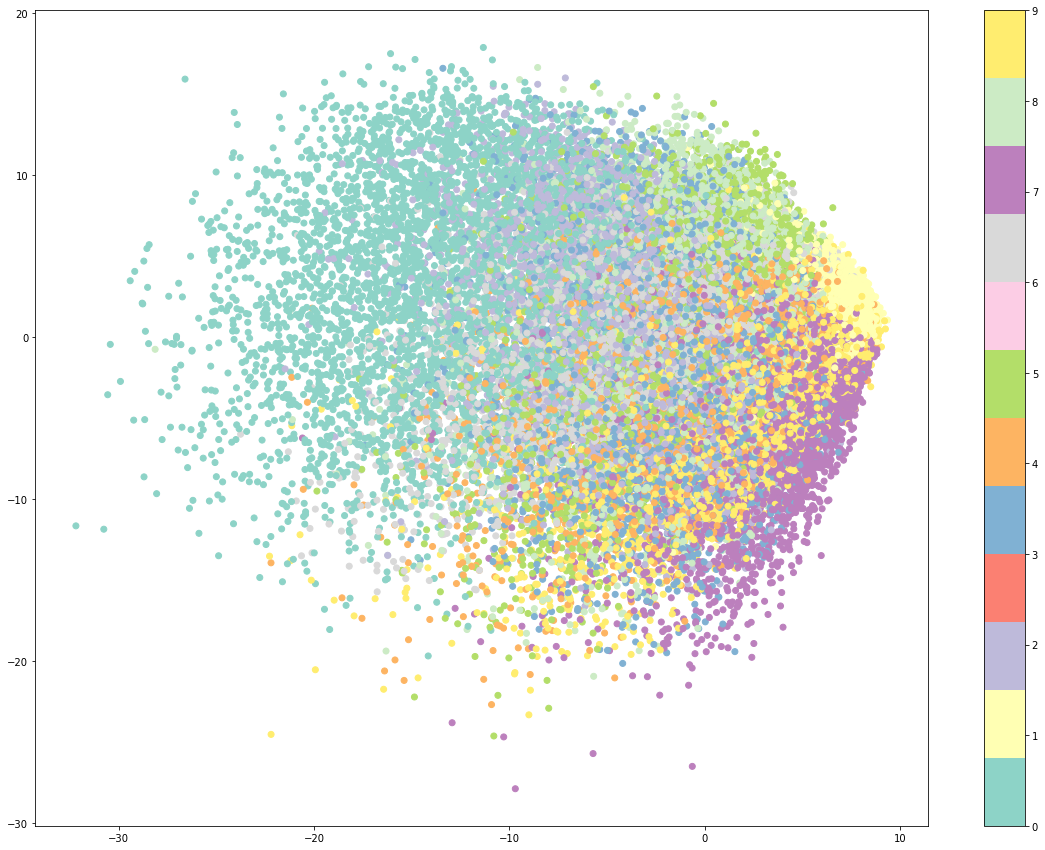

In [10]:
plt.figure(figsize=(20, 15))
plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='Set3')
plt.colorbar()

Мы можем линейно отделить некоторые классы друг от друга, но чётко разделить все точки на классы у нас не получится

In [11]:
X_train, X_test, labels_train, labels_test = train_test_split(X, labels)
X_train.shape, X_test.shape, labels_train.shape, labels_test.shape

((41250, 784), (13750, 784), (41250,), (13750,))

Изначально я начинал алгоритм с вычисления среднего и стандартного отклонения для тренировочной выборки. Но центрирование и нормировка тестовых данных с такими mean и std приводило к тому, что значения тренировочной и тестовой выборок в новом базисе отличались **примерно в 1e^10 раз.**
И алгоритм не работал – вероятно, расстояния считались некорректно

Чтобы решить это, я вычисляю mean и std для всех значений X и использую их для трансформирования тренировочной и тестовой выборок по отдельности.

В контексте абстрактной практической задачи, где у меня есть только тренировочная выборка и массив неподписанных неизвестных чисел, это бы работало так:
- Сначала выборка и массив объединяются, и для них вычисляется mean и std
- Потом выборка и массив трансформируются отдельно, и выборка отправляется в kNN.fit(), а массив – в kNN.predict()

*самое забавное, что это простое решение – плод бессоной ночи. Но главное – результат*

current n, k: (1, 1)
current n, k: (3, 1)
current n, k: (5, 1)
current n, k: (7, 1)
current n, k: (9, 1)
current n, k: (11, 1)
accuracy: [0.22341818181818182, 0.4570181818181818, 0.6805818181818182, 0.792, 0.7727272727272727, 0.7127272727272728]
current n, k: (1, 7)
current n, k: (3, 7)
current n, k: (5, 7)
current n, k: (7, 7)
current n, k: (9, 7)
current n, k: (11, 7)
accuracy: [0.2629818181818182, 0.5210181818181818, 0.7373090909090909, 0.8357818181818182, 0.8176727272727272, 0.7696]
current n, k: (1, 15)
current n, k: (3, 15)
current n, k: (5, 15)
current n, k: (7, 15)
current n, k: (9, 15)
current n, k: (11, 15)
accuracy: [0.2717090909090909, 0.5438545454545455, 0.7463272727272727, 0.8370181818181818, 0.8197090909090909, 0.7799272727272727]
current n, k: (1, 23)
current n, k: (3, 23)
current n, k: (5, 23)
current n, k: (7, 23)
current n, k: (9, 23)
current n, k: (11, 23)
accuracy: [0.27687272727272727, 0.5532363636363636, 0.7504727272727273, 0.8365818181818182, 0.8173090909090909,

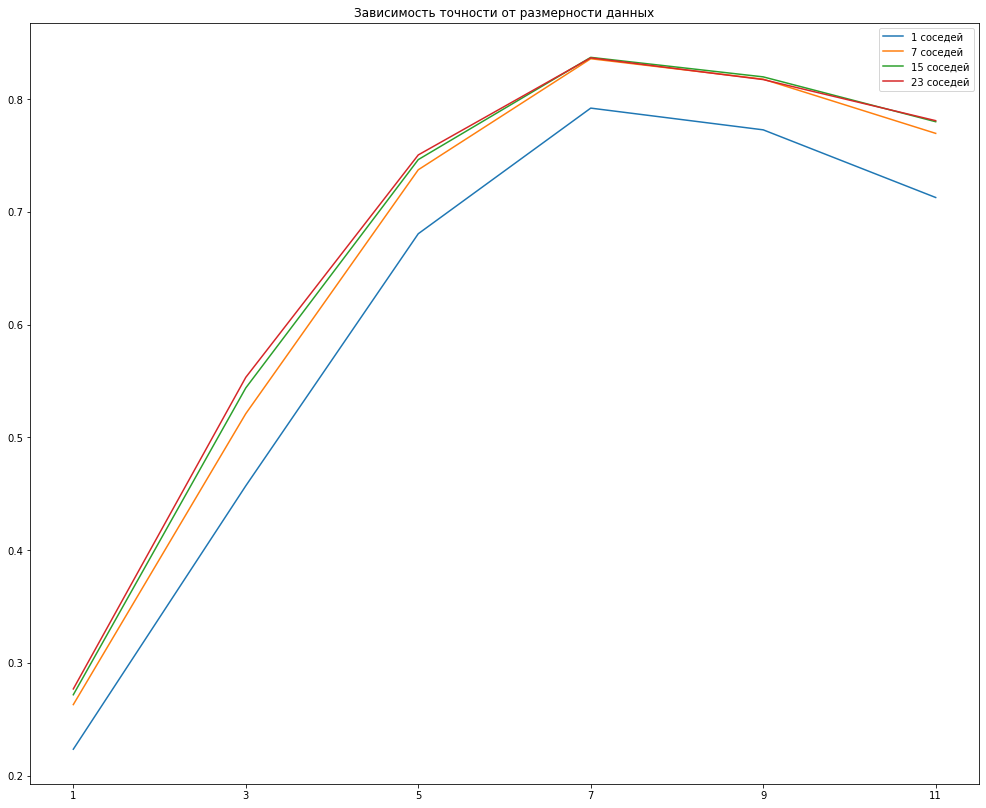

In [14]:
ticks = [1, 3, 5, 7, 9, 11]
plt.figure(figsize=(17,14))
for k in [1, 7, 15, 23]:
    acc = []
    for n in ticks:
        print('current n, k:', (n,k)) # этот print нужен, чтобы не скучать во время часового ожидания
        PCA = my_PCA(n)
        PCA.fit(X)
        _, X_training = PCA.transform(X_train)
        _, X_testing = PCA.transform(X_test)

        #print()
        #print(X_training, X_testing, sep='\n')
        #print()

        knn = my_kNN(k)
        knn.fit(X_training, labels_train)
        answers = knn.predict(X_testing)
        #print(answers)
        acc.append(accuracy_score(labels_test, answers))
        #print(acc)
    print('accuracy:', acc)
    plt.xticks(ticks)
    plt.title('Зависимость точности от размерности данных')
    plt.plot(ticks, acc, label=f'{k} соседей')
plt.legend()
plt.show()

### Вывод: 
Вне зависимости от числа ближайших соседей в алгоритме kNN, максимум точности достигается при **семи главных компонентах** (погрешность – единица, так как применить алгоритм для каждого натурального числа компонент тяжело)

**Число ближайших соседей не так сильно влияет на точность**, как количество главных компонент, но чем больше ближайших соседей – тем точнее алгоритм.